In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [3]:
from tensorflow.keras import optimizers, losses, layers, callbacks, preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard

In [4]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [5]:
df = pd.read_csv('data/creditcard.csv', header = 0, sep = ',')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
245406,152740.0,-1.239607,0.900667,0.340765,-1.100814,1.536239,-1.521851,2.202212,-0.983741,-0.307453,...,-0.079641,0.510472,-0.887206,0.089090,1.262835,0.339588,-0.011939,-0.355071,-0.045177,0
266008,162148.0,1.239027,-1.714418,-0.854948,0.443266,-1.020971,-0.153086,-0.198891,-0.023325,0.847783,...,0.439642,0.476090,-0.197562,-0.272985,-0.493959,0.611826,-0.115679,0.005121,1.230213,0
245635,152840.0,1.882061,0.138242,-1.350259,1.573954,0.203022,-0.594057,0.097806,-0.094958,0.394924,...,0.116151,0.585960,-0.023757,-0.066545,0.268071,-0.483595,0.033515,-0.028713,-0.239044,0
220113,142030.0,-0.926375,-0.916156,-1.490107,-0.095832,2.690137,-1.927147,0.351845,-0.078897,0.547888,...,0.250076,0.337981,0.694311,0.407516,-1.519677,-0.768896,0.292725,0.441844,0.017553,0
73705,55243.0,-0.405866,1.131222,1.415320,0.083690,0.106721,-0.691006,0.670947,0.015759,-0.498344,...,-0.209424,-0.472713,0.046131,0.363150,-0.259992,0.079694,0.266299,0.099226,-0.345313,0


In [9]:
df['Class'].value_counts()

0    20000
1      400
Name: Class, dtype: int64

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [11]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 12)                360       
                                                                 
 dense_1 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.compile(optimizer= RMSprop(), loss = 'mean_squared_error', metrics = ['mae', 'accuracy'])

In [13]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/simpleautoencoder')])

Epoch 1/20
510/510 [==============================] - 2s 2ms/step - loss: 1.5636 - mae: 0.6849 - accuracy: 0.2319 - val_loss: 1.6363 - val_mae: 0.6801 - val_accuracy: 0.4946
Epoch 2/20
510/510 [==============================] - 1s 2ms/step - loss: 1.5031 - mae: 0.6641 - accuracy: 0.5420 - val_loss: 1.6026 - val_mae: 0.6675 - val_accuracy: 0.5912
Epoch 3/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4885 - mae: 0.6593 - accuracy: 0.6353 - val_loss: 1.5956 - val_mae: 0.6660 - val_accuracy: 0.6645
Epoch 4/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4845 - mae: 0.6584 - accuracy: 0.6836 - val_loss: 1.5928 - val_mae: 0.6655 - val_accuracy: 0.6973
Epoch 5/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4820 - mae: 0.6580 - accuracy: 0.7108 - val_loss: 1.5909 - val_mae: 0.6653 - val_accuracy: 0.7189
Epoch 6/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4808 - mae: 0.6578 - accuracy: 0.7263 - val_loss: 1.59

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [39]:
%tensorboard --logdir ../logs/simpleautoencoder

In [16]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
# autoencoder 이므로 문제, 정답 둘다 x_test 들어가야함
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 1ms/step - loss: 1.5867 - mae: 0.6647 - accuracy: 0.7953
Test loss: 1.5867149829864502
Test accuracy: 0.6647059917449951


In [17]:
threshold = 10.0
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [18]:
import warnings
warnings.filterwarnings('ignore')
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3987
           1       0.38      0.76      0.51        93

    accuracy                           0.97      4080
   macro avg       0.69      0.87      0.75      4080
weighted avg       0.98      0.97      0.97      4080



In [19]:
threshold = 1
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_pred)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)
print(classification_report(y_test,  y_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3987
           1       0.02      1.00      0.04        93

    accuracy                           0.02      4080
   macro avg       0.01      0.50      0.02      4080
weighted avg       0.00      0.02      0.00      4080



In [20]:
threshold = 5
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)
print(classification_report(y_test,  y_label))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      3987
           1       0.08      0.91      0.15        93

    accuracy                           0.77      4080
   macro avg       0.54      0.84      0.51      4080
weighted avg       0.98      0.77      0.85      4080



In [21]:
threshold = 15
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)
print(classification_report(y_test,  y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.53      0.54      0.53        93

    accuracy                           0.98      4080
   macro avg       0.76      0.76      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [22]:
roc_auc_score(y_test, y_label)

0.763299271017905

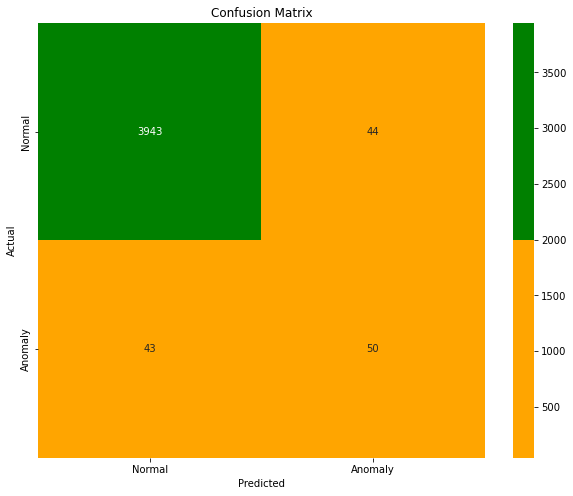

In [23]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

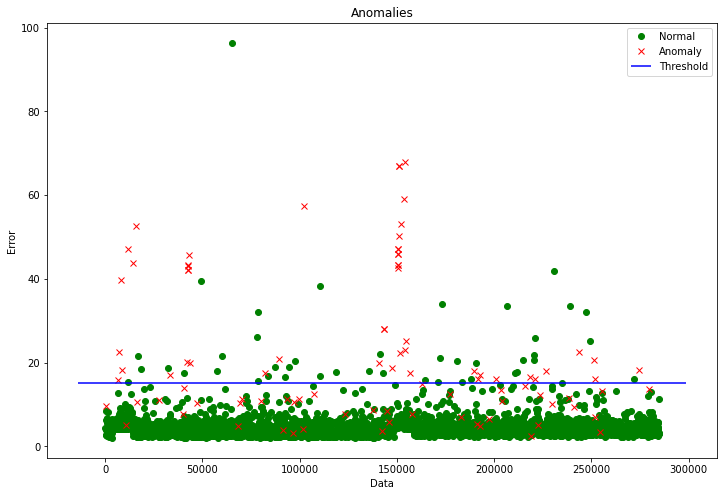

In [24]:
viz.draw_anomaly(y_test, error, threshold)

In [25]:
from tensorflow.keras import regularizers

In [26]:
encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

sparseautoencoder = Model(inputArray, decoded)
sparseautoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                360       
                                                                 
 dense_3 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [27]:
sparseautoencoder.compile(optimizer= RMSprop(), loss = 'mean_squared_error', metrics = ['mae', 'accuracy'])

In [28]:
batch_size = 32
epochs = 20

history = sparseautoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/sparseautoencoder')])

Epoch 1/20
510/510 [==============================] - 1s 2ms/step - loss: 1.5668 - mae: 0.6835 - accuracy: 0.2417 - val_loss: 1.6338 - val_mae: 0.6771 - val_accuracy: 0.4618
Epoch 2/20
510/510 [==============================] - 1s 1ms/step - loss: 1.5070 - mae: 0.6634 - accuracy: 0.5141 - val_loss: 1.6054 - val_mae: 0.6678 - val_accuracy: 0.5848
Epoch 3/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4920 - mae: 0.6596 - accuracy: 0.6221 - val_loss: 1.5988 - val_mae: 0.6663 - val_accuracy: 0.6618
Epoch 4/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4885 - mae: 0.6587 - accuracy: 0.6738 - val_loss: 1.5966 - val_mae: 0.6657 - val_accuracy: 0.6963
Epoch 5/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4868 - mae: 0.6582 - accuracy: 0.6983 - val_loss: 1.5952 - val_mae: 0.6654 - val_accuracy: 0.7152
Epoch 6/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4857 - mae: 0.6580 - accuracy: 0.7160 - val_loss: 1.59

In [40]:
%tensorboard --logdir ../logs/sparseautoencoder

In [41]:
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

deepencoder = Model(inputArray, decoded)
deepencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                480       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 29)                493 

In [42]:
deepencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [43]:
batch_size = 32
epochs = 20

history = deepencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 [==============================] - 2s 2ms/step - loss: 1.5790 - mae: 0.6883 - accuracy: 0.1928 - val_loss: 1.6564 - val_mae: 0.6840 - val_accuracy: 0.3199
Epoch 2/20
510/510 [==============================] - 1s 1ms/step - loss: 1.5246 - mae: 0.6665 - accuracy: 0.4161 - val_loss: 1.6217 - val_mae: 0.6691 - val_accuracy: 0.4828
Epoch 3/20
510/510 [==============================] - 1s 1ms/step - loss: 1.5094 - mae: 0.6606 - accuracy: 0.4872 - val_loss: 1.6165 - val_mae: 0.6674 - val_accuracy: 0.5137
Epoch 4/20
510/510 [==============================] - 1s 1ms/step - loss: 1.5057 - mae: 0.6599 - accuracy: 0.5127 - val_loss: 1.6129 - val_mae: 0.6668 - val_accuracy: 0.5319
Epoch 5/20
510/510 [==============================] - 1s 1ms/step - loss: 1.5025 - mae: 0.6594 - accuracy: 0.5302 - val_loss: 1.6095 - val_mae: 0.6665 - val_accuracy: 0.5412
Epoch 6/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4999 - mae: 0.6591 - accuracy: 0.5423 - val_loss: 1.60

In [44]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 942us/step - loss: 1.5867 - mae: 0.6647 - accuracy: 0.7953
Test loss: 1.5867149829864502
Test accuracy: 0.6647059917449951


In [45]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [46]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.53      0.54      0.53        93

    accuracy                           0.98      4080
   macro avg       0.76      0.76      0.76      4080
weighted avg       0.98      0.98      0.98      4080



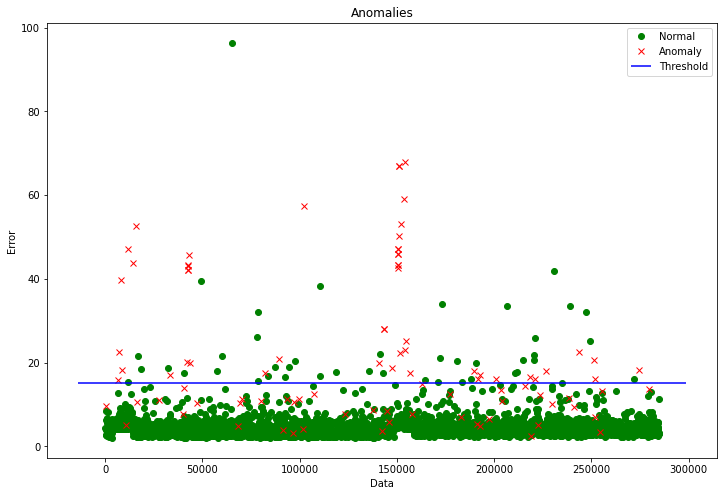

In [47]:
viz.draw_anomaly(y_test, error, threshold)